In [3]:
# Загрузим библиотеки, которые нам пригодятся

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Загрузим датасет
mnist = fetch_openml('mnist_784', as_frame=False, cache=True)

# подготовим данные в нужном формате
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

# Оставим в датасете только классы 0 и 1
y_bin = y[(y == 0) | (y == 1)]
X_bin = X[(y == 0) | (y == 1)]


# Для удобства, обозначим лейблы классов за -1 (обозначает цифру 0)
# и 1 (обозначает цифру 1)
y_bin[y_bin == 0] = -1

# Посмотрим на долю единиц в датасете
positive_class_size = len(y_bin[y_bin == 1])
positive_class_rate = positive_class_size / len(y_bin)
print("Доля единиц в датасете: ", positive_class_rate)

Доля единиц в датасете:  0.5329499323410013


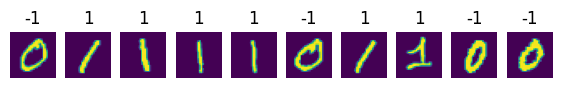

In [3]:
# Посмотрим на первые 5 примеров

n = 10

fig, axs = plt.subplots(1, n, figsize=(7, 3))

for ax, image, label in zip(axs, X_bin[:n], y_bin[:n]):

  # Переводим картинку из вектора длины 784 в матрицу 28 x 28
  image_reshaped = image.reshape(28, 28)

  ax.imshow(image_reshaped)
  ax.set_title(label)
  ax.axis("off")

### Шаг 1: Тренировка незащищенной модели

In [5]:
# Импортируем необходимые библиотеки
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler


# Разделим датасет на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_bin, y_bin, test_size=0.2, random_state=42)

# Нормализуем данные
X_train /= 255
X_test /= 255

# Тренируем модель логистической регрессии
model = LogisticRegression(max_iter=1000, solver='lbfgs')
model.fit(X_train, y_train)

# Оценим точность модели на тестовом наборе
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели на чистом тестовом наборе: {accuracy:.4f}")

Точность модели на чистом тестовом наборе: 0.9997


### Шаг 2: Проведение Атаки на Логистическую Регрессию
Реализуем оптимальную атаку на модель, чтобы проверить, насколько сильно падает ее точность.

In [6]:
# Определим максимальное изменение каждого пикселя
epsilon = 0.2

# Получим весовые коэффициенты модели
weights = model.coef_
sign_weights = np.sign(weights)

# Вычислим оптимальную атаку
def optimal_attack(X, y, weights, epsilon):
    delta = -y[:, np.newaxis] * epsilon * np.sign(weights)
    return X + delta

In [7]:
# Атака на тестовый набор
X_test_attacked = optimal_attack(X_test, y_test, weights, epsilon)

# Точность на атакованном тестовом наборе
y_pred_attacked = model.predict(X_test_attacked)
accuracy_attacked = accuracy_score(y_test, y_pred_attacked)
print(f"Точность на атакованном тестовом наборе: {accuracy_attacked:.4f}")

Точность на атакованном тестовом наборе: 0.0873


### Шаг 3: Реализация Robust Classifier

Создадим робастную модель классификации.

In [8]:
from sklearn.base import BaseEstimator
#from sklearn.metrics import log_loss

class RobustLogisticRegression(BaseEstimator):
    def __init__(self, learning_rate=0.01, max_iter=1000, epsilon=0.2):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.weights = None
        self.bias = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _loss(self, X, y):
        z = X @ self.weights + self.bias
        margin = y * z - self.epsilon * np.sum(np.abs(self.weights))
        return np.mean(np.log(1 + np.exp(-margin)))

    def fit(self, X, y):
        # Добавим смещение к признакам
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.max_iter):
            z = X @ self.weights + self.bias
            predictions = self._sigmoid(z)

            # Градиент обновлений
            gradient_w = -(y * (1 - predictions)) @ X / n_samples
            gradient_b = -np.mean(y * (1 - predictions))

            # Учитываем робастность
            gradient_w += self.epsilon * np.sign(self.weights)

            # Обновление весов
            self.weights -= self.learning_rate * gradient_w
            self.bias -= self.learning_rate * gradient_b

    def predict(self, X):
        return np.sign(X @ self.weights + self.bias)

In [9]:
# Тренируем модель робастной логистической регрессии
robust_model = RobustLogisticRegression(learning_rate=0.01, max_iter=1000, epsilon=0.2)
robust_model.fit(X_train, y_train)

# Оценим точность робастной модели на чистом тестовом наборе
y_pred_robust = robust_model.predict(X_test)
accuracy_robust = accuracy_score(y_test, y_pred_robust)
print(f"Точность робастной модели на чистом тестовом наборе: {accuracy_robust:.4f}")


Точность робастной модели на чистом тестовом наборе: 0.9915


In [10]:
# Применим оптимальную атаку на робастную модель
weights_robust = robust_model.weights
X_test_attacked_robust = optimal_attack(X_test, y_test, weights_robust, epsilon)


In [11]:
# Оценим точность робастной модели на атакованном тестовом наборе
y_pred_attacked_robust = robust_model.predict(X_test_attacked_robust)
accuracy_attacked_robust = accuracy_score(y_test, y_pred_attacked_robust)
print(f"Точность робастной модели на атакованном тестовом наборе: {accuracy_attacked_robust:.4f}")

Точность робастной модели на атакованном тестовом наборе: 0.9100


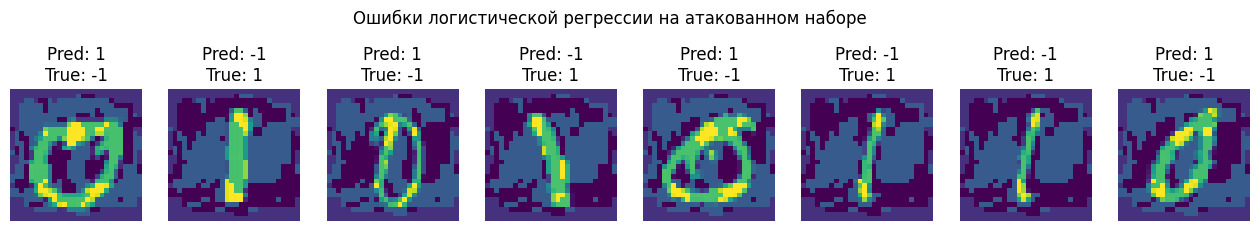

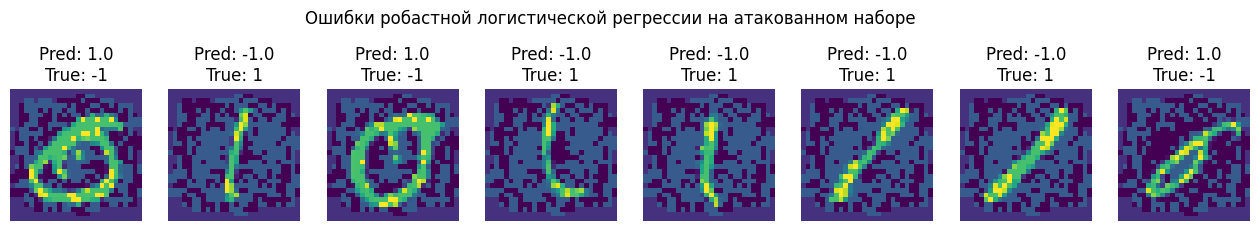

In [12]:
# визуализация # выводит ошибки обычной и робастной модели
import matplotlib.pyplot as plt

def visualize_misclassifications(X, y_true, y_pred, title, num_images=8):
    misclassified_indices = np.where(y_true != y_pred)[0]
    num_misclassified = len(misclassified_indices)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 3))
    if num_misclassified == 0:
        print(f"Нет ошибок для {title}")
        return

    
    for i, index in enumerate(misclassified_indices[:num_images]):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X[index].reshape(28, 28),)
        plt.title(f"Pred: {y_pred[index]}\nTrue: {y_true[index]}")
        plt.axis('off')
    plt.suptitle((title))
    plt.show()

# Визуализация ошибок обычной модели на атакованном тестовом наборе
visualize_misclassifications(X_test_attacked, y_test, y_pred_attacked, "Ошибки логистической регрессии на атакованном наборе")

# Визуализация ошибок робастной модели на атакованном тестовом наборе
visualize_misclassifications(X_test_attacked_robust, y_test, y_pred_attacked_robust, "Ошибки робастной логистической регрессии на атакованном наборе")

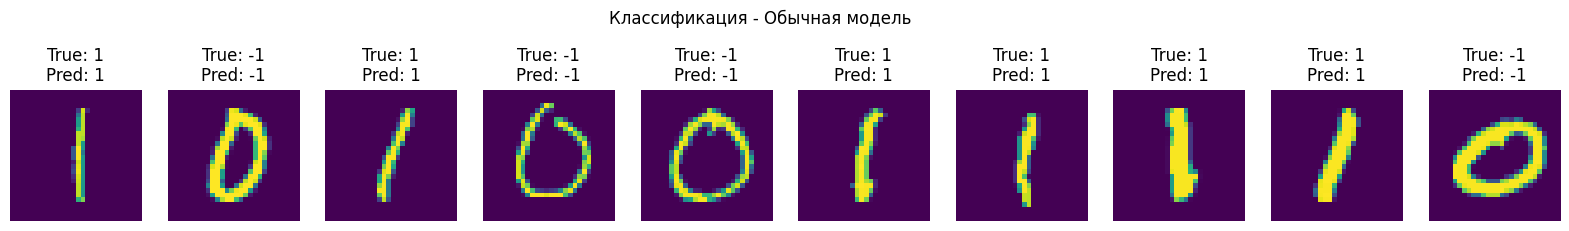

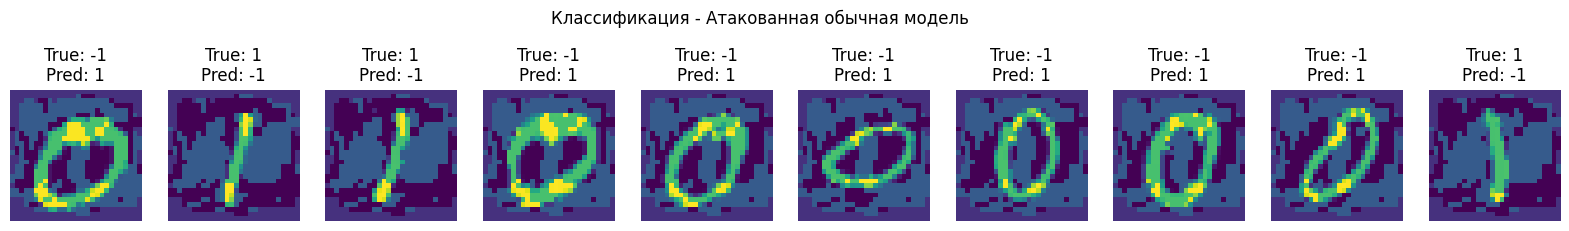

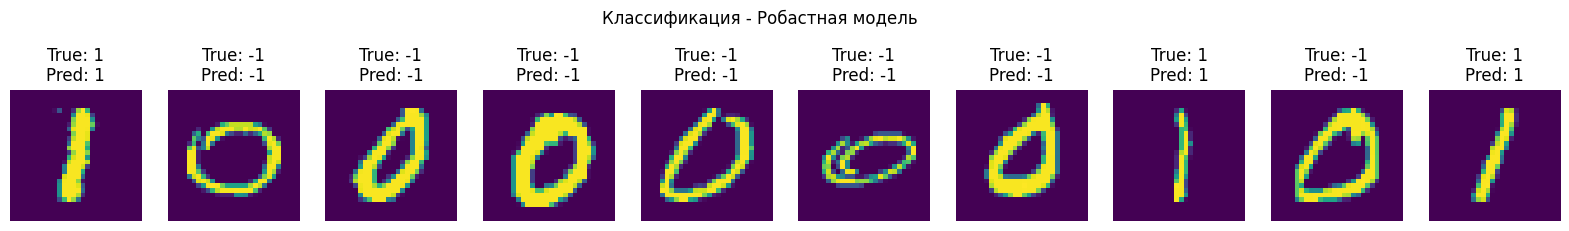

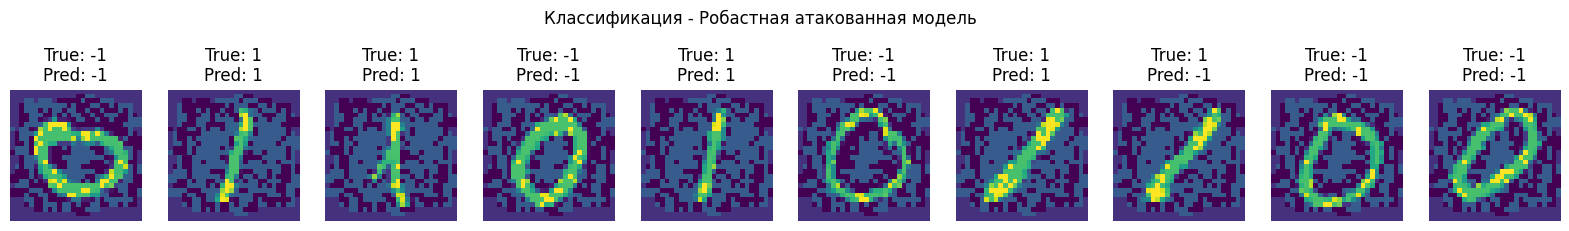

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_random_images(X, y, model, model_name, num_images=10):
    '''визуализация случайных картинок'''
    indices = np.random.choice(range(len(X)), num_images, replace=False)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 3))
    
    for i, idx in enumerate(indices):
        ax = axes[i]
        ax.imshow(X[idx].reshape(28, 28))
        ax.set_title(f'True: {y[idx]}\nPred: {int(model.predict(X[idx].reshape(1, -1))[0])}')
        ax.axis('off')
    
    plt.suptitle(f'Классификация - {model_name}')
    plt.show()

# классификация обычной модели на чистых данных
plot_random_images(X_test, y_test, model, "Обычная модель")

# классификация обычной модели на атакованных данных
plot_random_images(X_test_attacked, y_test, model, "Атакованная обычная модель")

# классификация робастной модели на чистых данных
plot_random_images(X_test, y_test, robust_model, "Робастная модель")

# классификация робастной модели на атакованных данных
plot_random_images(X_test_attacked_robust, y_test, robust_model, "Робастная атакованная модель")

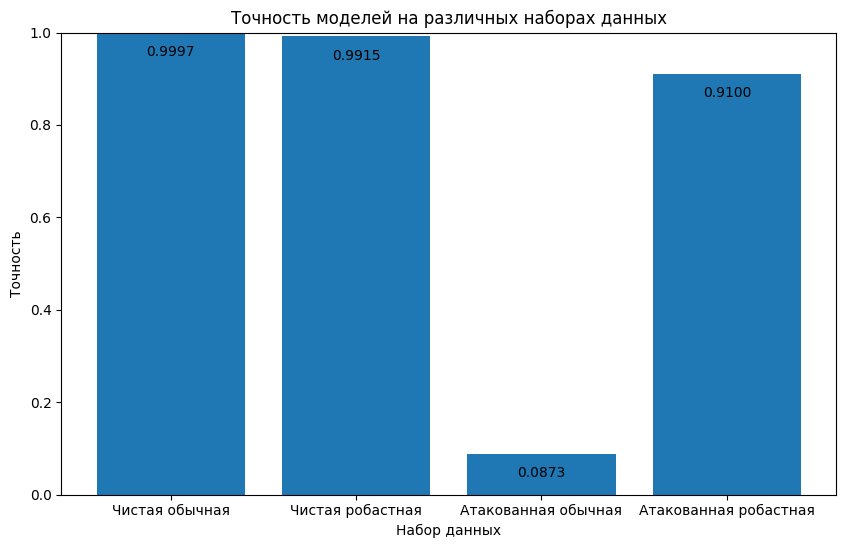

In [14]:
import seaborn as sns

# Точности для разных наборов данных
accuracy_clean = model.score(X_test, y_test)
accuracy_attacked = model.score(X_test_attacked, y_test)
accuracy_robust_clean = np.mean(robust_model.predict(X_test) == y_test)
accuracy_robust_attacked = np.mean(robust_model.predict(X_test_attacked_robust) == y_test)

# Список точностей
accuracies = [accuracy_clean, accuracy_robust_clean, accuracy_attacked, accuracy_robust_attacked]
labels = ['Чистая обычная',  'Чистая робастная','Атакованная обычная', 'Атакованная робастная']

# Создание графика
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracies)

# Добавление подписей для каждого столбца
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() - 0.05, 
             f'{accuracy:.4f}', 
             ha='center', 
             color='black', 
             fontsize=10)

plt.xlabel('Набор данных')
plt.ylabel('Точность')
plt.title('Точность моделей на различных наборах данных')
plt.ylim([0, 1]) 
plt.show()


В зависимости от версии используемого python значение точности для атакованной обычной модели может отличаться. Я использовал версию 3.12.2

In [15]:
# Применим неоптимальную атаку на робастную модель
X_test_attacked_robust_no = optimal_attack(X_test, y_test, weights, epsilon)

In [16]:
# Оценим точность робастной модели на атакованном тестовом наборе
y_pred_attacked_robust_no = robust_model.predict(X_test_attacked_robust_no)
accuracy_attacked_robust_no = accuracy_score(y_test, y_pred_attacked_robust_no)
print(f"Точность робастной модели на атакованном тестовом наборе: {accuracy_attacked_robust_no:.4f}")

Точность робастной модели на атакованном тестовом наборе: 0.9797


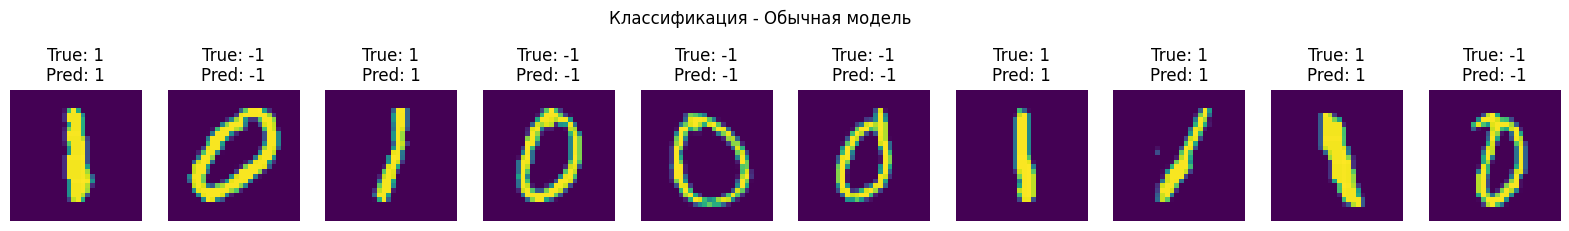

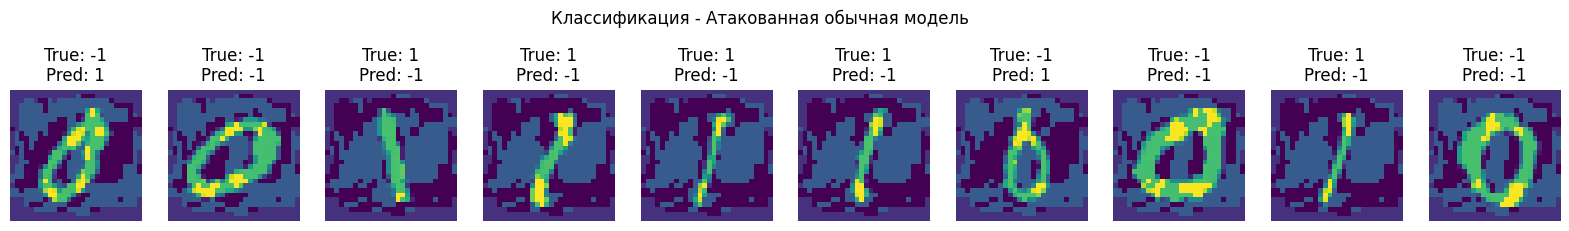

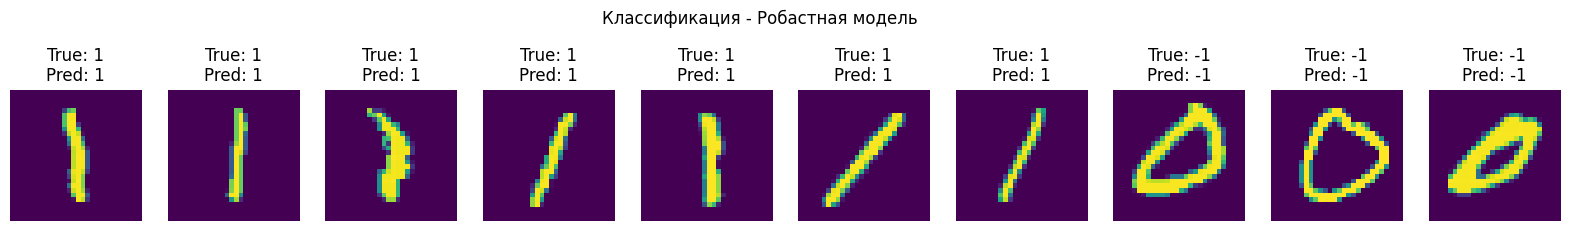

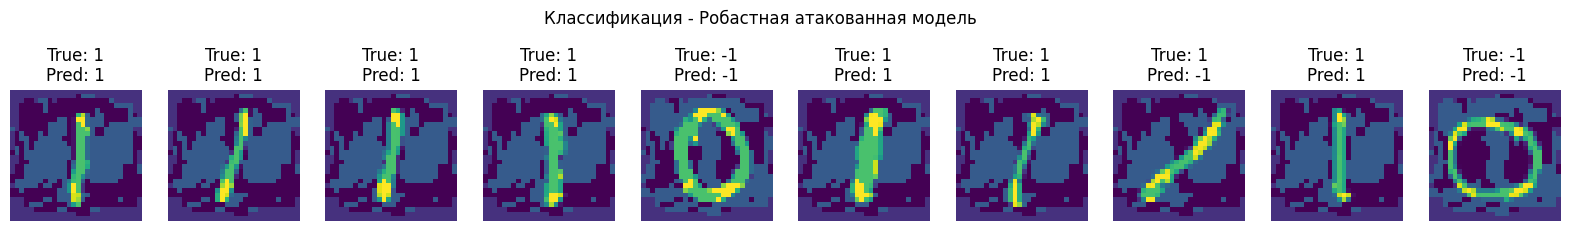

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def plot_random_images(X, y, model, model_name, num_images=10):
    '''визуализация случайных картинок'''
    indices = np.random.choice(range(len(X)), num_images, replace=False)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 3))
    
    for i, idx in enumerate(indices):
        ax = axes[i]
        ax.imshow(X[idx].reshape(28, 28))
        ax.set_title(f'True: {y[idx]}\nPred: {int(model.predict(X[idx].reshape(1, -1))[0])}')
        ax.axis('off')
    
    plt.suptitle(f'Классификация - {model_name}')
    plt.show()

# классификация обычной модели на чистых данных
plot_random_images(X_test, y_test, model, "Обычная модель")

# классификация обычной модели на атакованных данных
plot_random_images(X_test_attacked, y_test, model, "Атакованная обычная модель")

# классификация робастной модели на чистых данных
plot_random_images(X_test, y_test, robust_model, "Робастная модель")

# классификация робастной модели на атакованных данных
plot_random_images(X_test_attacked_robust_no, y_test, robust_model, "Робастная атакованная модель")